In [1]:
# imports
# -------

# imports
# -------
import numpy as np
import random
import copy
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time
import multiprocessing
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
import scipy.misc
from scipy.ndimage import label



# torch related imports
# ---------------------
import torch
from torch.autograd import Variable
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.utils import save_image
import torch.optim as optim


%matplotlib inline
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


# code

### 1. helper functions

In [2]:
# GENERIC function to calculate conv outsize
# -------------------------------------------- 
def outsize_conv(n_H,n_W,f,s,pad):
    
    h = ((n_H - f + (2*pad))/s) + 1
    w = ((n_W - f + (2*pad))/s) + 1
    return h,w
    
    
# GENERIC function to calculate upconv outsize
# --------------------------------------------    
def outsize_upconv(h,w,f,s,p):
    hout = (h-1)*s - 2*p + f
    wout = (w-1)*s - 2*p + f
    return hout, wout



# GENERIC - initialises weights for a NN
# --------------------------------------
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
        
# GENERIC - change an torch image to numpy image
# ----------------------------------------------
def to_numpy_image(xin):
    
    try:
        xin = xin.data.numpy()
    except:
        xin = xin.numpy()
    
    xout = np.swapaxes(xin,1,2)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped numpy images
    # ---------------------------------
    return xout       



# GENERIC - converts numpy images to torch tensors for training
# -------------------------------------------------------------
def setup_image_tensor(xin):
    xout = np.swapaxes(xin,1,3)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped torch tensor
    # ---------------------------------
    xout = torch.from_numpy(xout)
    return xout.float()

In [3]:
# GENERIC - change an torch image to numpy image
# ----------------------------------------------
def to_numpy_image(xin):
    
    try:
        xin = xin.data.numpy()
    except:
        xin = xin.numpy()
    
    xout = np.swapaxes(xin,1,2)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped numpy images
    # ---------------------------------
    return xout       



# GENERIC - converts numpy images to torch tensors for training
# -------------------------------------------------------------
def setup_image_tensor(xin):
    xout = np.swapaxes(xin,1,3)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped torch tensor
    # ---------------------------------
    xout = torch.from_numpy(xout)
    return xout.float()


In [4]:
# simple regression accuracy function
# -----------------------------------


def reg_accuracy(p,t,sim_threshold):
    
    '''
    
    should be np array
    
    '''
    
    # 1. 
    # do min/max
    # ----------
    min_max = np.minimum(p,t)/np.maximum(p,t)
    
    # 2. mean sim
    # ------------
    mean_sim = np.mean(min_max, axis = 1)
    
    # 3.
    # threshold
    # ---------
    sum_greater_than_threshold = np.sum(mean_sim > sim_threshold)
    per = round(sum_greater_than_threshold/p.shape[0], 2) * 100
    
    # 4. final print
    # --------------
    print('got right: ' + str(sum_greater_than_threshold) + '/' + str(p.shape[0]) + ' (' + str(per) + ' %)')
    
    
    


In [5]:
# pooled function to build dataset
# --------------------------------

def create_trainset_pool(base_folder, h_in, w_in, mb_size, print_status_in):
    
    # need code to create triplets of arrays for fixed size given an input folder
    # ---------------------------------------------------------------------------
    
    '''
    
    ex_img_name = '2011_10_03_drive_0047_sync_image_0000000716_image_03.png'
    ex_dep_name = '2011_10_03_drive_0047_sync_groundtruth_depth_0000000716_image_03.png'

    ex_col_img_url = base_folder + 'image/' + ex_img_name
    ex_dep_img_url = base_folder + 'groundtruth_depth/' + ex_dep_name

    '''
    
    # 0. inits
    # --------
    global print_status
    print_status = print_status_in
    
    global counter
    counter = 0

    global images_folder
    images_folder = base_folder + 'image/' 

    global labels_folder
    labels_folder = base_folder + 'groundtruth_depth/'

    global r_h, r_w
    r_h, r_w = h_in, w_in

    # 1. getting list of training images from folder
    # always of extension jpg/jpeg
    # -----------------------------------------------
    global image_list
    image_list = [f for f in listdir(images_folder) if isfile(join(images_folder, f)) and '.png' in f.lower()]
    image_list = random.sample(image_list, mb_size)

    # initialising outputs
    # --------------------
    global x_input
    x_input = np.zeros((len(image_list), r_h, r_w, 3))
    
    global x_target
    x_target = np.zeros((len(image_list), r_h, r_w, 1))
    

    # 2. calling pooled functino
    # --------------------------
    pool = ThreadPool(5) 
    pool.map(create_trainset_single, list(range(len(image_list))))
    if print_status == True:
        print('Done. access at global x_input, x_target.')
    
    # closing pools
    # -------------
    pool.terminate()
    pool.join()
    

    
    
# single function
# ---------------
def create_trainset_single(i):
    
    # 0. global inits
    # ---------------
    global images_folder
    global labels_folder
    global r_h, r_w
    global image_list
    global x_input
    global counter
    global x_target
    
    global print_status
    
    
    # 2. this is pooled function
    # --------------------------

    # 1. getting all images
    # ---------------------
    curr_name = image_list[i]
    curr_label_name = curr_name.replace('_sync_image_','_sync_groundtruth_depth_')
    curr_image = cv2.resize(cv2.cvtColor(cv2.imread(images_folder + curr_name), cv2.COLOR_BGR2RGB), (r_w, r_h), interpolation = cv2.INTER_NEAREST)
    curr_label = cv2.resize(cv2.cvtColor(cv2.imread(labels_folder + curr_label_name), cv2.COLOR_BGR2RGB), (r_w, r_h), interpolation = cv2.INTER_NEAREST)


    # 2. assign to global final arrays - thats it
    # -------------------------------------------
    x_input[i] = curr_image
    x_target[i] = curr_label[:,:,0].reshape(r_h,r_w,1) # since the other channels simply repeat values ##
    counter += 1 
    
    # sanity
    # ------
    if print_status == True:
        print('done with ' + str(counter) + ' of around ' + str(len(image_list)) + ' images...', end='\r')
    


### 2. model related codes

In [6]:
# a function to load a saved model
# --------------------------------

def load_saved_model_function_cpu(path):
    
    
    ''' path = /folder1/folder2/model_ae.tar format'''
    
    # 1. loading full model
    # ---------------------
    model = torch.load(path.replace('.tar','_MODEL.tar'))
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    
    # 2. Applying state dict
    # loads to CPU
    # torch.load(checkpoint_file, map_location=‘cpu’)
    # ------------------------------------------------
    checkpoint = torch.load(path, map_location='cpu')
    
    # loading checkpoint
    # -------------------
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # loading optimizer
    # -----------------
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    
    # loading other stuff
    # -------------------
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    loss_mode = checkpoint['loss_mode']
    
    # just return model only
    # ----------------------
    return model, optimizer, epoch, loss, loss_mode
    

In [7]:
# GENERIC model function to train the networks
# --------------------------------------------
def model_train(base_train_url,load_mode,model,epochs,mbsize,save_state,base_name,path):
    
    
    # 0. initialisations
    # x_small,y = create_multiclass_trainset_pool(master_url,img_h,img_w,use_grayscale,None)
    # --------------------------------------------------------------------------------------
    
    
    # 1. OPTIMIZER SETTINGS
    # WGAN values from paper
    # https://arxiv.org/pdf/2006.14380.pdf
    # optimiser is ADAM
    ######################################
    #criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    device = torch.device("cpu")
    cpu_device = torch.device("cpu")
    
    use_cuda = False
    if use_cuda == True:
        device = torch.device('cuda')
    loss_mode = 'mse'
    img_h, img_w = 255, 255
    global x_input, x_target
    
    
    # 2. loading model
    # eiher from saved state or new
    # -----------------------------
    if load_mode == 'from saved':
        
        # 1. 
        # loading GEN from saved
        # ----------------------
        model,optimizer,saved_epoch,saved_loss,saved_loss_mode = load_saved_model_function_cpu(path + base_name + '.tar')
        model = model.to(cpu_device)        
        model = model.train()
        
        print('Loading model from saved state...')
        print('Last saved recons loss - ' + str(saved_loss))
        print('Last saved recons epoch - ' + str(saved_epoch))
        epochs += int(saved_epoch)
        start_epoch = int(saved_epoch)
        print('**********************')
        
        
        
    else:
        
        # building new
        # ------------
        start_epoch = 1
        
        # 1. GEN
        # ------
        model = model.train()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))

        
  
    
    # 3. multi GPU support
    ##############################
    ##############################
    # MAIN MULTI GPU SUPPORT CODE
    # https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html#create-model-and-dataparallel
    # ------------------------------------------------------------------------------------------------------

    # over here we will consider the model to be of NOT dataparrale + cuda  optimised
    # if multi GPU available
    # -------------------------------------------------------------------------------
    if use_cuda == True:

        # gen
        # ---
        model.to(device)
        
        # updating optimiser
        # -------------------
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)

          
        # sanity
        # ------
        print("finished setting models up for GPU..")
    
            
    # 4. MAIN ACTUAL ITERS
    #######################
    #######################
    #######################
    for i in range(start_epoch,epochs+1):
        
            
        ###################################
        # this is random based train method
        ###################################

        # 1. randomly sampling from disk
        # just use x_input and x_target from this function
        # -----------------------------------------------
        create_trainset_pool(base_folder, img_h, img_w, mbsize, False)
        

        # augmenting data on the go
        # -------------------------
        x_input_trn = Variable(setup_image_tensor(x_input)).float()
        x_input_trn = x_input_trn/torch.max(x_input_trn)
        x_target_trn = Variable(setup_image_tensor(x_target)).float()


        # 3. moving to gpu
        # ----------------
        x_input_trn = x_input_trn.to(device)
        x_target_trn = x_target_trn.to(device)


        # 4. main training ops
        # --------------------
        optimizer.zero_grad()
        model_out = model(x_input_trn)
        loss = criterion(model_out, x_target_trn) # input, target
        loss.backward()
        optimizer.step()

        
        # 5. printing ops
        # ---------------
        split_loss = 'MSE loss: ' + str(round(loss.item(),3))
        if i%5 == 0:
            print('Epoch ' + str(i) + ':' + split_loss)
        
        
        # 6. saving model
        # ---------------
        if save_state == True and i%100 == 0:

            
            # sanity
            # ------
            time.sleep(3)

            # 1.
            # saving model
            # initialising save dict
            # ----------------------
            save_dict = {}
            save_dict['epoch'] = str(i)
            save_dict['model_state_dict'] = model.cpu().state_dict()
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
            save_dict['loss'] = str(loss.cpu().item())
            save_dict['loss_mode'] = loss_mode

            # 3.2 saving
            # ----------
            curr_path = path + base_name + '.tar'
            torch.save(save_dict,curr_path)

            # saving full model to initialise a new model later on
            # ----------------------------------------------------
            torch.save(model.cpu(),curr_path.replace('.tar','_MODEL.tar'))
            print('intermediate SAVE - model saved at epoch: ' + str(i))

            # if multi GPU available
            # ----------------------
            if use_cuda == True:

                # model
                # -----
                model.to(device)

   
    
    # 4. return model in order to use elsewhere in the code
    # -----------------------------------------------------
    return model
        


In [8]:
# end of all code
#

# models

In [9]:
# FCN class copied from image search notebook which worked
# generator_1_127 latent_dim, line_in_channels, design_in_channels, out_channels return_encoded_latents
# --------------------------------------------------------

class fcn_UNET_depthperception(nn.Module):
    def __init__(self):
        super().__init__()
        
        # AIMING FOR THIS TO BE A FCNs
        ##############################
        # generator with RELU and discrimitor with leaky relu
        
         # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.LeakyReLU(0.2) #nn.LeakyReLU(0.2) #nn.ReLU() # nn.ReLU() #nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        dropout_prob = 0.1
        dropout_node = nn.Dropout2d(p=dropout_prob)
        self.main_latent_dim = 128

        # 1. image encoder
        # ----------------
        # 00.
        ####
        conv00_ch = 32
        ct00 = nn.Conv2d(3,conv00_ch,f,stride = s)
        cb00 = nn.BatchNorm2d(conv00_ch)
        ca00 = nw_activation_conv
        self.cl00 = nn.Sequential(*[ct00,cb00,ca00,dropout_node])
        # 127

        # 0.
        ####
        conv0_ch = 32
        ct0 = nn.Conv2d(conv00_ch,conv0_ch,f,stride = s)
        cb0 = nn.BatchNorm2d(conv0_ch)
        ca0 = nw_activation_conv
        self.cl0 = nn.Sequential(*[ct0,cb0,ca0,dropout_node])
        # 63
        
        # 1.
        ####
        conv1_ch = 64
        ct1 = nn.Conv2d(conv0_ch,conv1_ch,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1_ch)
        ca1 = nw_activation_conv
        self.cl1 = nn.Sequential(*[ct1,cb1,ca1,dropout_node])
        # 31
        
        # 2.
        ####
        conv2_ch = 128
        ct2 = nn.Conv2d(conv1_ch,conv2_ch,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2_ch)
        ca2 = nw_activation_conv
        self.cl2 = nn.Sequential(*[ct2,cb2,ca2,dropout_node])
        # 15
        
        # 3.
        ####
        conv3_ch = 256
        ct3 = nn.Conv2d(conv2_ch,conv3_ch,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3_ch)
        ca3 = nw_activation_conv
        self.cl3 = nn.Sequential(*[ct3,cb3,ca3,dropout_node])
        # 7
        
        # 4.
        ####
        conv4_ch = 512
        ct4 = nn.Conv2d(conv3_ch,conv4_ch,f,stride = s)
        cb4 = nn.BatchNorm2d(conv4_ch)
        ca4 = nw_activation_conv
        self.cl4 = nn.Sequential(*[ct4,cb4,ca4,dropout_node])
        # 3

        # 5.
        ####
        ct5 = nn.Conv2d(conv4_ch,self.main_latent_dim,f,stride = s)
        ca5 = nw_activation_conv
        self.cl5 = nn.Sequential(*[ct5,ca5,dropout_node])
        # 1


        #################################################
        #################################################
        #################################################

        # GETTING INTO UPCONS
        # -------------------
        # Upconv layer 1
        ###
        t1 = nn.ConvTranspose2d(self.main_latent_dim,conv4_ch,f,stride = s)
        b1 = nn.BatchNorm2d(conv4_ch)
        a1 = nw_activation_conv
        self.ul1 = nn.Sequential(*[t1,b1,a1,dropout_node])
        # 3x3
        
        # Upconv layer 2
        ###
        t2 = nn.ConvTranspose2d(conv4_ch*2,conv3_ch,f,stride = s)
        b2 = nn.BatchNorm2d(conv3_ch)
        a2 = nw_activation_conv
        self.ul2 = nn.Sequential(*[t2,b2,a2,dropout_node])
        # 7
        
        # Upconv layer 3
        ###
        t3 = nn.ConvTranspose2d(conv3_ch*2,conv2_ch,f,stride = s)
        b3 = nn.BatchNorm2d(conv2_ch)
        a3 = nw_activation_conv
        self.ul3 = nn.Sequential(*[t3,b3,a3,dropout_node])
        # 15
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(conv2_ch*2,conv1_ch,f,stride = s)
        b4 = nn.BatchNorm2d(conv1_ch)
        a4 = nw_activation_conv
        self.ul4 = nn.Sequential(*[t4,b4,a4,dropout_node])
        # 31
        
        # Upconv layer 5
        ###
        t5 = nn.ConvTranspose2d(conv1_ch*2,conv0_ch,f,stride = s)
        b5 = nn.BatchNorm2d(conv0_ch)
        a5 = nw_activation_conv
        self.ul5 = nn.Sequential(*[t5,b5,a5,dropout_node])
        # 63
        
        
        # Upconv layer 6
        ###
        t6 = nn.ConvTranspose2d(conv0_ch*2,conv00_ch,f,stride = s)
        b6 = nn.BatchNorm2d(conv00_ch)
        a6 = nw_activation_conv
        self.ul6 = nn.Sequential(*[t6,b6,a6,dropout_node])
        # 63
        

        # Upconv layer 6
        # the outputs would be logits
        ###
        t7 = nn.ConvTranspose2d(conv00_ch*2,conv00_ch,f,stride = s)
        b7 = nn.BatchNorm2d(conv00_ch)
        a7 = nw_activation_conv
        t7_f = nn.ConvTranspose2d(conv00_ch,1,1,stride = 1)
        self.ul7 = nn.Sequential(*[t7,b7,a7,t7_f,a7])
        # 127

       

    def forward(self, x):
        
        # encoding
        # --------
        conv00_out = self.cl00(x)
        conv0_out = self.cl0(conv00_out)
        conv1_out = self.cl1(conv0_out)
        conv2_out = self.cl2(conv1_out)
        conv3_out = self.cl3(conv2_out)
        conv4_out = self.cl4(conv3_out)
        conv5_out = self.cl5(conv4_out)


   
        # straightforward outs
        # --------------------
        up1_out = self.ul1(conv5_out)
        up2_out = self.ul2(torch.cat((up1_out, conv4_out), 1))
        up3_out = self.ul3(torch.cat((up2_out, conv3_out), 1))
        up4_out = self.ul4(torch.cat((up3_out, conv2_out), 1))
        up5_out = self.ul5(torch.cat((up4_out, conv1_out), 1))
        up6_out = self.ul6(torch.cat((up5_out, conv0_out), 1))
        up7_out = self.ul7(torch.cat((up6_out, conv00_out), 1))
        
        # using torch.exp to expand model prediction
        ##
        final_out = torch.exp(up7_out)
        
        
        # final return
        # ------------
        return final_out
    
    
   

In [95]:
# FCN class copied from image search notebook which worked
# generator_1_127 latent_dim, line_in_channels, design_in_channels, out_channels return_encoded_latents
# --------------------------------------------------------

class fcn_UNET_depthperception_15(nn.Module):
    def __init__(self):
        super().__init__()
        
        # AIMING FOR THIS TO BE A FCNs
        ##############################
        # generator with RELU and discrimitor with leaky relu
        
         # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.LeakyReLU(0.2) #nn.LeakyReLU(0.2) #nn.ReLU() # nn.ReLU() #nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        dropout_prob = 0.1
        dropout_node = nn.Dropout2d(p=dropout_prob)
        self.main_latent_dim = 128

        # 1. image encoder
        # ----------------
        # 00.
        ####
        conv00_ch = 32
        ct00 = nn.Conv2d(3,conv00_ch,f,stride = s)
        cb00 = nn.BatchNorm2d(conv00_ch)
        ca00 = nw_activation_conv
        self.cl00 = nn.Sequential(*[ct00,cb00,ca00,dropout_node])
        # 127

        # 0.
        ####
        conv0_ch = 64
        ct0 = nn.Conv2d(conv00_ch,conv0_ch,f,stride = s)
        cb0 = nn.BatchNorm2d(conv0_ch)
        ca0 = nw_activation_conv
        self.cl0 = nn.Sequential(*[ct0,cb0,ca0,dropout_node])
        # 63
        
        # 1.
        ####
        conv1_ch = 128
        ct1 = nn.Conv2d(conv0_ch,conv1_ch,f,stride = s)
        #cb1 = nn.BatchNorm2d(conv1_ch)
        ca1 = nw_activation_conv
        self.cl1 = nn.Sequential(*[ct1,ca1,dropout_node])
        # 31
        
        # 2.
        ####
        conv2_ch = 256
        ct2 = nn.Conv2d(conv1_ch,conv2_ch,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2_ch)
        ca2 = nw_activation_conv
        self.cl2 = nn.Sequential(*[ct2,cb2,ca2,dropout_node])
        # 15
        
        # 3.
        ####
        #conv3_ch = 256
        #ct3 = nn.Conv2d(conv2_ch,conv3_ch,f,stride = s)
        #cb3 = nn.BatchNorm2d(conv3_ch)
        #ca3 = nw_activation_conv
        #self.cl3 = nn.Sequential(*[ct3,cb3,ca3,dropout_node])
        # 7
        
        # 4.
        ####
        #conv4_ch = 512
        #ct4 = nn.Conv2d(conv3_ch,conv4_ch,f,stride = s)
        #cb4 = nn.BatchNorm2d(conv4_ch)
        #ca4 = nw_activation_conv
        #self.cl4 = nn.Sequential(*[ct4,cb4,ca4,dropout_node])
        # 3

        # 5.
        ####
        #ct5 = nn.Conv2d(conv4_ch,self.main_latent_dim,f,stride = s)
        #ca5 = nw_activation_conv
        #self.cl5 = nn.Sequential(*[ct5,ca5,dropout_node])
        # 1


        #################################################
        #################################################
        #################################################

        # GETTING INTO UPCONS
        # -------------------
        # Upconv layer 1
        ###
        #t1 = nn.ConvTranspose2d(self.main_latent_dim,conv4_ch,f,stride = s)
        #b1 = nn.BatchNorm2d(conv4_ch)
        #a1 = nw_activation_conv
        #self.ul1 = nn.Sequential(*[t1,b1,a1,dropout_node])
        # 3x3
        
        # Upconv layer 2
        ###
        #t2 = nn.ConvTranspose2d(conv4_ch*2,conv3_ch,f,stride = s)
        #b2 = nn.BatchNorm2d(conv3_ch)
        #a2 = nw_activation_conv
        #self.ul2 = nn.Sequential(*[t2,b2,a2,dropout_node])
        # 7
        
        # Upconv layer 3
        ###
        #t3 = nn.ConvTranspose2d(conv3_ch*2,conv2_ch,f,stride = s)
        #b3 = nn.BatchNorm2d(conv2_ch)
        #a3 = nw_activation_conv
        #self.ul3 = nn.Sequential(*[t3,b3,a3,dropout_node])
        # 15
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(conv2_ch,conv1_ch,f,stride = s)
        b4 = nn.BatchNorm2d(conv1_ch)
        a4 = nw_activation_conv
        self.ul4 = nn.Sequential(*[t4,b4,a4,dropout_node])
        # 31
        
        # Upconv layer 5
        ###
        t5 = nn.ConvTranspose2d(conv1_ch*2,conv0_ch,f,stride = s)
        b5 = nn.BatchNorm2d(conv0_ch)
        a5 = nw_activation_conv
        self.ul5 = nn.Sequential(*[t5,b5,a5,dropout_node])
        # 63
        
        
        # Upconv layer 6
        ###
        t6 = nn.ConvTranspose2d(conv0_ch*2,conv00_ch,f,stride = s)
        b6 = nn.BatchNorm2d(conv00_ch)
        a6 = nw_activation_conv
        self.ul6 = nn.Sequential(*[t6,b6,a6,dropout_node])
        # 63
        

        # Upconv layer 6
        # the outputs would be logits
        ###
        t7 = nn.ConvTranspose2d(conv00_ch*2,conv00_ch,f,stride = s)
        b7 = nn.BatchNorm2d(conv00_ch)
        a7 = nw_activation_conv
        t7_f = nn.ConvTranspose2d(conv00_ch,1,1,stride = 1)
        self.ul7 = nn.Sequential(*[t7,b7,a7,t7_f,a7])
        # 127

       

    def forward(self, x):
        
        # encoding
        # --------
        conv00_out = self.cl00(x)
        conv0_out = self.cl0(conv00_out)
        conv1_out = self.cl1(conv0_out)
        conv2_out = self.cl2(conv1_out)
        #conv3_out = self.cl3(conv2_out)
        #conv4_out = self.cl4(conv3_out)
        #conv5_out = self.cl5(conv4_out)


   
        # straightforward outs
        # --------------------
        #up1_out = self.ul1(conv5_out)
        #up2_out = self.ul2(torch.cat((up1_out, conv4_out), 1))
        #up3_out = self.ul3(torch.cat((up2_out, conv3_out), 1))
        up4_out = self.ul4(conv2_out)
        up5_out = self.ul5(torch.cat((up4_out, conv1_out), 1))
        up6_out = self.ul6(torch.cat((up5_out, conv0_out), 1))
        up7_out = self.ul7(torch.cat((up6_out, conv00_out), 1))
        
        # using torch.exp to expand model prediction
        ##
        final_out = torch.exp(up7_out)
        
        
        # final return
        # ------------
        return final_out
    
    
   

In [10]:
# end of models and all code
##

# execution

### 1. visualise dataset

In [11]:
# main folder setups
# base folder 
# -- labels -- train, val (png)
# -- color_labels -- train, val (png)
# -- images -- test, train, val (jpgs)
# ------------------------------------

base_folder = '/Users/venkateshmadhava/Documents/eplane/projects/datasets/depth_selection/val_selection_cropped/'

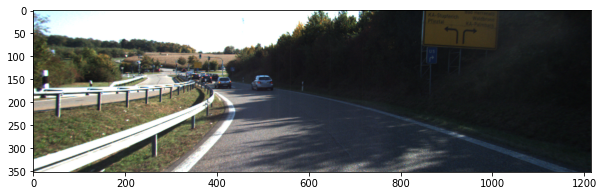

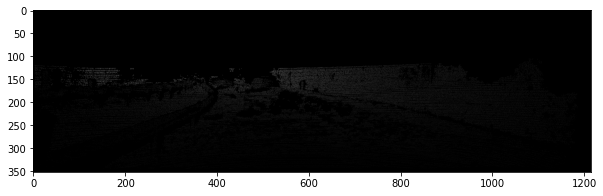

In [12]:
# example showing
# ---------------

ex_img_name = '2011_10_03_drive_0047_sync_image_0000000716_image_03.png'
ex_dep_name = '2011_10_03_drive_0047_sync_groundtruth_depth_0000000716_image_03.png'

ex_col_img_url = base_folder + 'image/' + ex_img_name
ex_dep_img_url = base_folder + 'groundtruth_depth/' + ex_dep_name

# reading images
# --------------
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cv2.imread(ex_col_img_url), cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(10,10))
ex_labels = cv2.cvtColor(cv2.imread(ex_dep_img_url), cv2.COLOR_BGR2RGB)
plt.imshow(ex_labels)
plt.show()

In [13]:
# printing unique values in labels where every pixel is classified among one of 19 classes
# we will use this to build target maps
# ----------------------------------------------------------------------------------------

np.unique(ex_labels)

array([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81], dtype=uint8)

[ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 77 78 79 80]
(300, 300, 3)


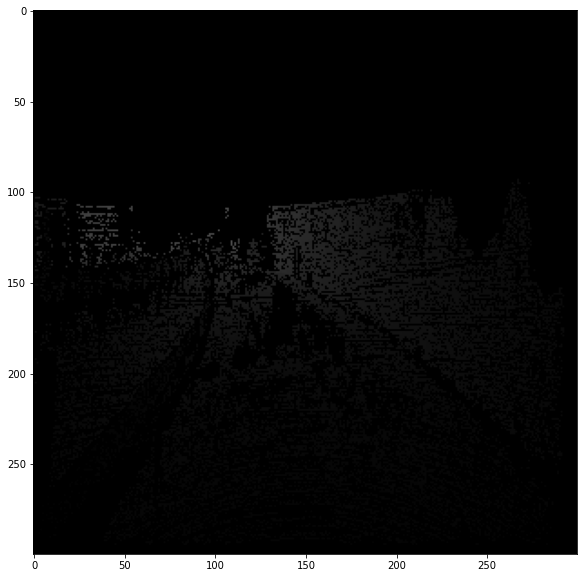

In [14]:
# resize and view - resize with fixed interpolation from CV2
# ----------------------------------------------------------

plt.figure(figsize=(10,10))
im_r = cv2.resize(ex_labels, (300,300), interpolation = cv2.INTER_NEAREST)
print(np.unique(im_r))
print(im_r.shape)
plt.imshow(im_r)

In [15]:
# simply checking up values
# not able to understand these value
# ----------------------------------

print(np.mean(im_r[200:300,50:200,0])) # shallow region -- the road
print(np.mean(im_r[150:175,200:250,0])) # wall region - side wall

2.478266666666667
9.9952


In [16]:
# End of stuff here
##

### 2. training data visualisation

In [19]:
# set the number of classes we want to segment (including 0)
# set up h,w
# create traing data
# ----------------------------------------------------------

create_trainset_pool(base_folder, 255, 255, 8, True)

Done. access at global x_input, x_target.


In [20]:
# global data shapes for ref
# --------------------------
global x_input, x_target
x_input_ex, x_target_ex = x_input, x_target
del x_input, x_target

print(x_input_ex.shape)
print(x_target_ex.shape)

(8, 255, 255, 3)
(8, 255, 255, 1)


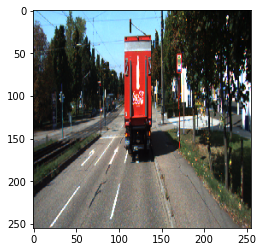

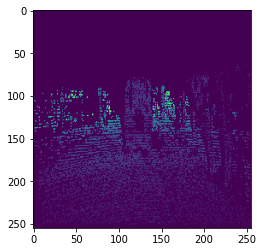

In [21]:
# showing random data
# -------------------
randrange = random.sample(list(range(x_input_ex.shape[0])), 1)

for i in randrange:
    plt.imshow(x_input_ex[i].astype('uint8'))
    plt.show()
    plt.imshow(x_target_ex[i].astype('uint8'))
    plt.show()

### 3. model setup

In [22]:
# snippet to work out filter sizes
# --------------------------------
f = 3
s = 2
pad = 0
layers = 7

h = 255
w = 255
print('Showing conv down sizes - ')
print('--------------------------')
# showing out sizes after conv
# ----------------------------
for _ in range(layers):   
    h,w = outsize_conv(h,w,f,s,pad)
    print((h,w))
    
h = 1
w = 1
print('\nShowing conv up sizes - ')
print('--------------------------')

# showing out sizes after conv
# ----------------------------
for _ in range(layers):   
    h,w = outsize_upconv(h,w,f,s,pad)
    print((h,w))


Showing conv down sizes - 
--------------------------
(127.0, 127.0)
(63.0, 63.0)
(31.0, 31.0)
(15.0, 15.0)
(7.0, 7.0)
(3.0, 3.0)
(1.0, 1.0)

Showing conv up sizes - 
--------------------------
(3, 3)
(7, 7)
(15, 15)
(31, 31)
(63, 63)
(127, 127)
(255, 255)


### 3.1 model training

In [96]:
# initialising model
# ------------------

model_dep = fcn_UNET_depthperception_15()
model_dep.apply(weights_init)
model_dep
print('model created')

model created


In [231]:
# training loop
# -------------

# model_train(base_train_url,len_classlabels,load_mode,model,epochs,mbsize,save_state,base_name,path)


# model save path set up
# ----------------------
cn_save_path = '/Users/venkateshmadhava/Documents/eplane/projects/code/models/'

# declaring base name
# -------------------
base_name = 'eplane_depth_perception'


# training
# --------
model_dep = model_train(base_folder,'from saved',model_dep,-1,4,True,base_name,cn_save_path)

Loading model from saved state...
Last saved recons loss - 2.130040168762207
Last saved recons epoch - 6200
**********************


In [232]:
# end of training code
##

### 3.2 inference

orig image - 


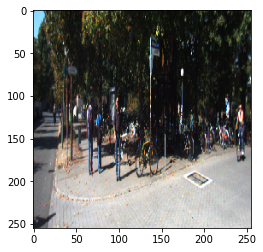

orig depth - 


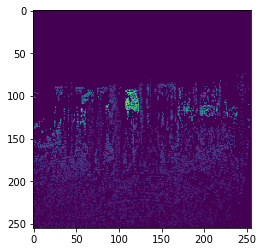

predicted depth - 


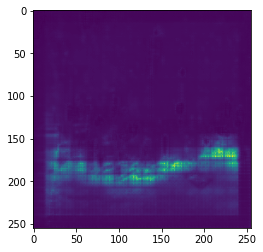

In [236]:
# train set inference
# -------------------
randrange = random.sample(list(range(x_input_ex.shape[0])), 1)

# orig inputs
# -----------
x_input_train_inf = x_input_ex[randrange]
x_target_train_inf = x_target_ex[randrange]


# model out
# ---------
x_target_model_out = model_dep.eval()(Variable(setup_image_tensor(x_input_train_inf)).float()/np.max(x_input_train_inf))
x_target_model_out_np = to_numpy_image(x_target_model_out)


# plotting
# ---------
for i in range(x_input_train_inf.shape[0]):
    
    print('orig image - ')
    plt.imshow(x_input_train_inf[i].astype('uint8'))
    plt.show()
    
    # overlayed - 
    # ----------
    print('orig depth - ')
    plt.imshow(x_target_train_inf[i].astype('uint8'))
    plt.show()
    
    # overlayed - 
    # ----------
    print('predicted depth - ')
    plt.imshow(x_target_model_out_np[i])
    plt.show()
    
    
    
    # overlayed - 
    # ----------
    #print('original overlayed - ')
    #plt.imshow(((x_target_train_inf[i]).astype('uint8') * 0.5 + x_input_train_inf[i].astype('uint8') * 0.5).astype('uint8'))
    #plt.show()
    
    # overlayed - 
    # ----------
    #print('predicted overlayed - ')
    #plt.imshow(((x_target_model_out_np[i]*255).astype('uint8') * 0.5 + x_input_train_inf[i].astype('uint8') * 0.5).astype('uint8'))
    #plt.show()
    

In [135]:
# end of inference
#

### 3.3 accuracy class wise

In [225]:
# printing accuracy metrics
# -------------------------

p = x_target_model_out.detach().numpy().reshape(x_target_model_out.size()[0],-1)
t = x_target_train_inf.reshape(x_target_train_inf.shape[0],-1)

reg_accuracy(p,t,0.5)

got right: 0/1 (0.0 %)


# rough